In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
# Japan example
command_file_name = "../data/command/japan_command_new.json"

# Western North America example
# command_file_name = "../data/command/western_north_america_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

2022-05-18 11:41:56.689 | INFO     | celeri.celeri:get_logger:107 - Read: ../data/command/japan_command.json
2022-05-18 11:41:56.690 | INFO     | celeri.celeri:get_logger:108 - RUN_NAME: 2022-05-18-11-41-56
2022-05-18 11:41:56.690 | INFO     | celeri.celeri:get_logger:109 - Write log file: ../runs/2022-05-18-11-41-56/2022-05-18-11-41-56.log
2022-05-18 11:41:56.690 | INFO     | celeri.celeri:read_data:114 - Reading data files
2022-05-18 11:41:56.695 | SUCCESS  | celeri.celeri:read_data:118 - Read: ../data/segment/japan_segment.csv
2022-05-18 11:41:56.697 | SUCCESS  | celeri.celeri:read_data:123 - Read: ../data/block/japan_block.csv
2022-05-18 11:41:56.698 | SUCCESS  | celeri.celeri:read_data:130 - Read: ../data/mesh/japan_mesh_parameters.json


Warning: The file contains tag data that couldn't be processed.

2022-05-18 11:41:56.723 | SUCCESS  | celeri.celeri:read_data:236 - Read: ../data/mesh/nankai.msh


Warning: The file contains tag data that couldn't be processed.

2022-05-18 11:41:56.760 | SUCCESS  | celeri.celeri:read_data:236 - Read: ../data/mesh/japan.msh


Warning: The file contains tag data that couldn't be processed.

2022-05-18 11:41:56.792 | SUCCESS  | celeri.celeri:read_data:236 - Read: ../data/mesh/sagami.msh
2022-05-18 11:41:56.797 | SUCCESS  | celeri.celeri:read_data:272 - Read: ../data/station/japan_station.csv
2022-05-18 11:41:56.798 | INFO     | celeri.celeri:read_data:287 - No mogi_file_name
2022-05-18 11:41:56.799 | INFO     | celeri.celeri:read_data:309 - No sar_file_name


# Get elastic operators and TDE smoothing operators

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2022-05-18 11:42:01.181 | INFO     | celeri.celeri:get_elastic_operators:1492 - Using precomputed elastic operators


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2022-05-18 11:42:05.330 | INFO     | celeri.celeri:get_slip_rate_constraints:1164 - No slip rate constraints


# Plot input data

In [ ]:
celeri.plot_input_summary(command, segment, station, block, meshes, mogi, sar, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [7]:
index, estimation = celeri.assemble_and_solve_dense(command, assembly, operators, station, block, meshes)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary

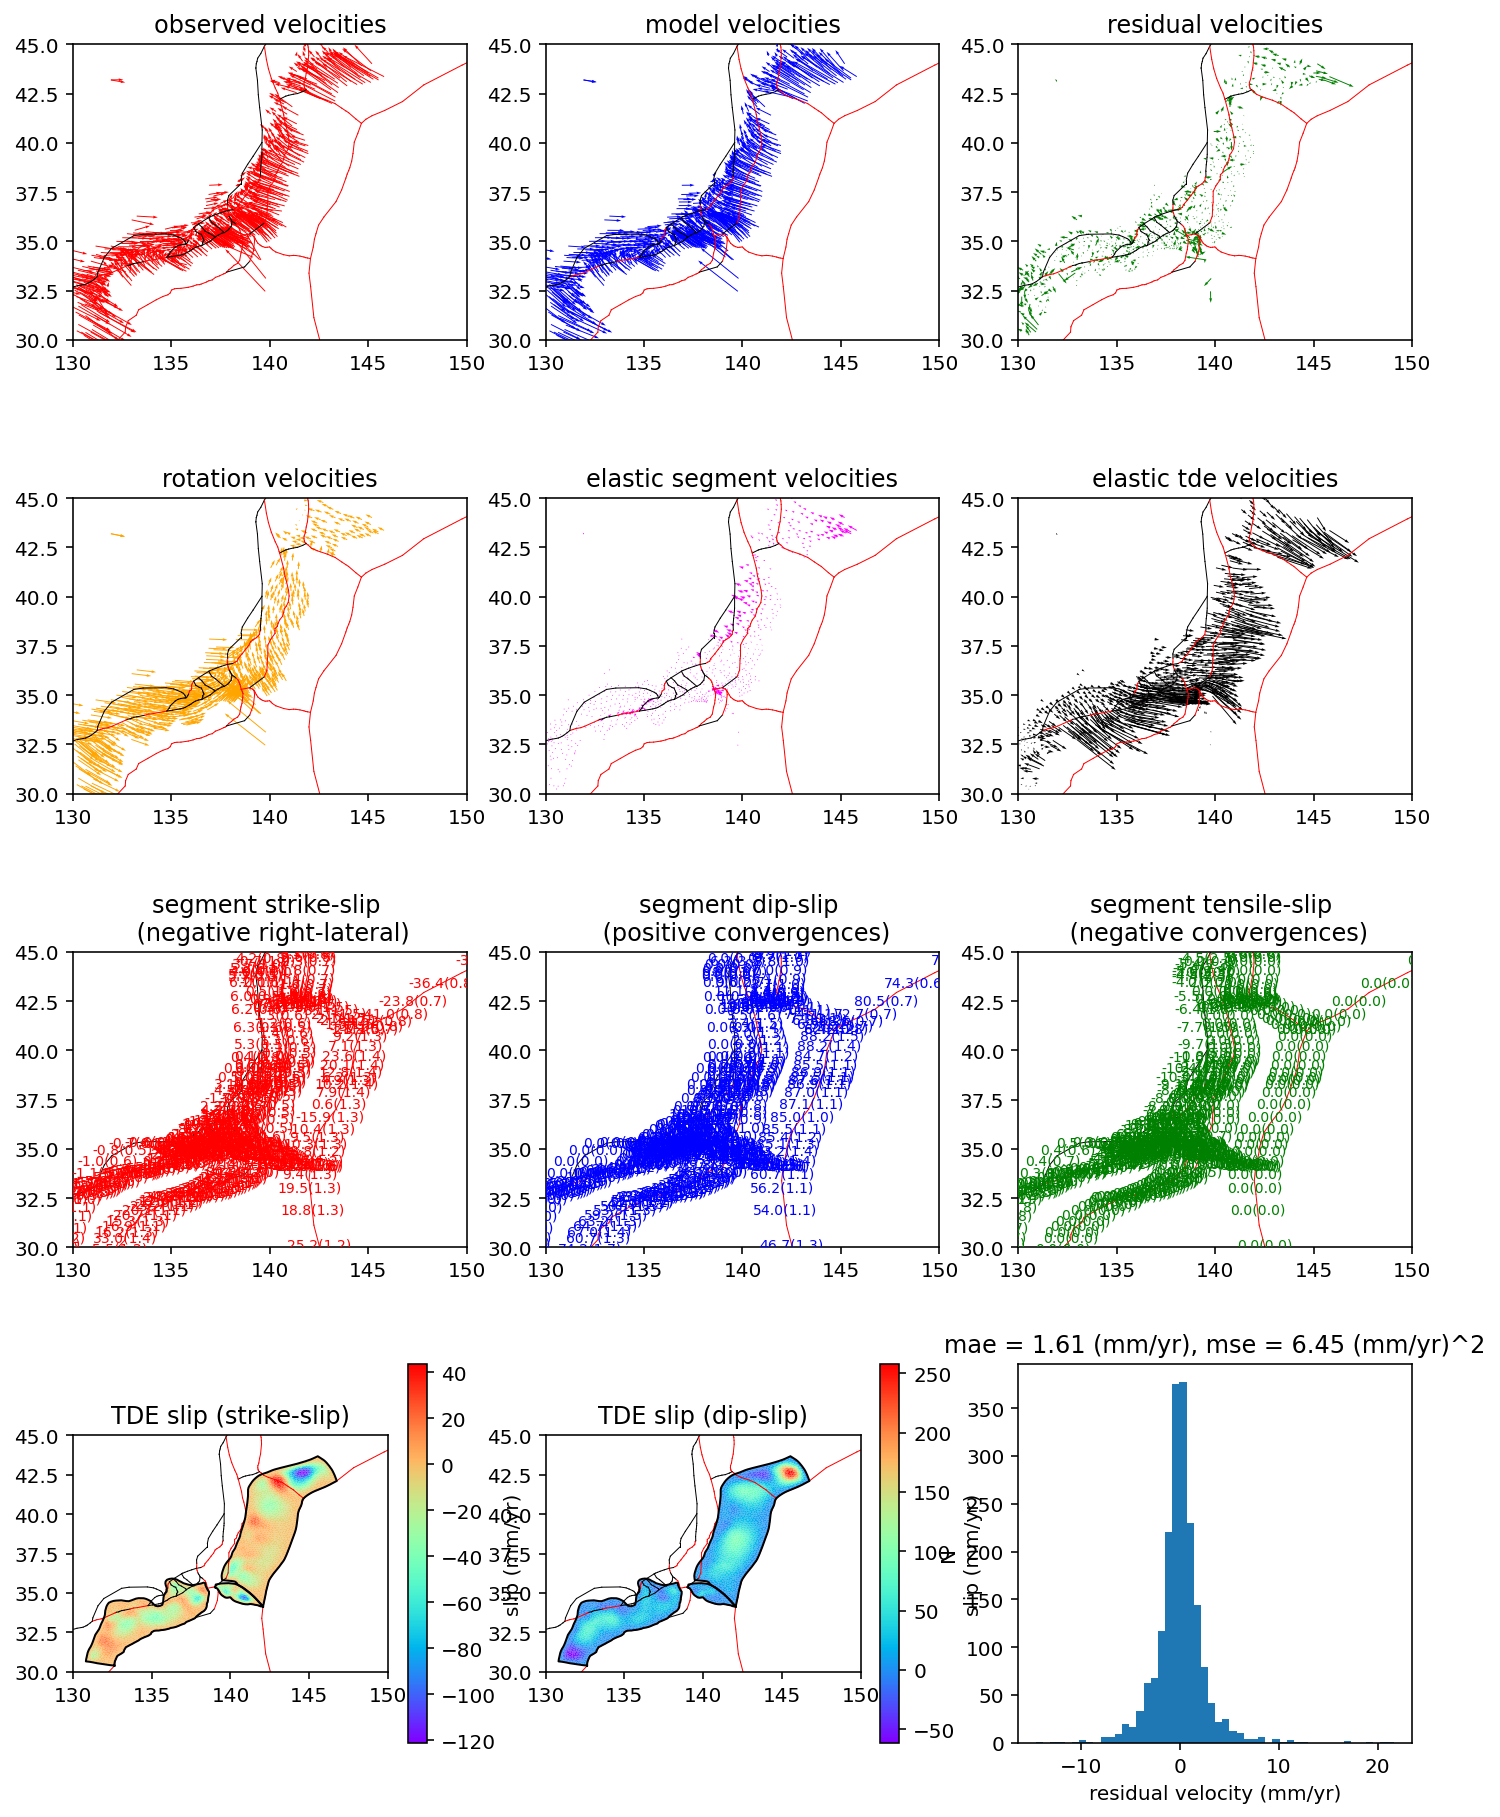

2022-05-18 11:42:50.267 | SUCCESS  | celeri.celeri:plot_estimation_summary:4497 - Wrote figures../runs/2022-05-18-11-41-56/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [8]:
celeri.plot_estimation_summary(command, segment, station, meshes, estimation, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)